In [2]:
setwd("/mnt/c/git_repos/blood_microbial_signatures/")
require(tidyverse)
require(data.table)
require(foreach)
require(doParallel)
require(voronoiTreemap)
require(randomcoloR)
require(htmlwidgets)
registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.3”
Warning message:
“package ‘readr’ was built under R version 4.1.3”
Warning message:
“package ‘purrr’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Warning messa

#### Load data

In [3]:
df <- fread("data/blood_culture_records/blood_culture_records.parsed.csv") %>%
    mutate(id = str_glue("{patientcode}_{aclast4digits}_{sex}_{race}"))

dict <- fread("data/blood_culture_records/organisms_dict.csv")
colnames(dict) <- c("organisms", "taxa")

df <- df %>% 
    left_join(dict) %>%
    mutate(organisms = gsub("[0-9]", "", organisms),
           taxa = gsub("\\.[0-9]", "", taxa)) %>%
    mutate(taxa = tolower(taxa))

df_unique <- df %>% distinct(patientcode, aclast4digits, yearcollected, .keep_all = T)
head(df_unique)

Joining with `by = join_by(organisms)`


hosp,patientcode,aclast4digits,sex,age,race,location,organisms,culturetype,yearcollected,id,taxa
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<glue>,<chr>
SGH,AM,142H,M,76,I,S73,,DBARD,2011,AM_142H_M_I,NA
SGH,AB,493D,M,47,M,S55B,,DBARD,2011,AB_493D_M_M,NA
SGH,AA,431F,F,46,O,S78,,DBARD,2011,AA_431F_F_O,NA
SGH,AA,885B,F,36,O,S78,,DBARD,2011,AA_885B_F_O,NA
SGH,AA,000I,F,36,O,S47A,,DBARD,2011,AA_000I_F_O,NA
SGH,AA,698D,F,36,O,S47A,,DBARD,2011,AA_698D_F_O,NA


## Parse records

In [4]:
df_na <- df %>%
    filter(is.na(taxa)) %>%
    distinct(id, taxa, .keep_all = T)

df_pos <- df %>% 
    filter(!is.na(taxa)) %>%
    mutate(organisms = ifelse(grepl("Strept.pneumo|Strep.pneumo", taxa, ignore.case = T), "SPN", organisms),
           taxa = ifelse(grepl("Strept.pneumo|Strep.pneumo", taxa, ignore.case = T), "streptococcus pneumoniae", taxa)) %>%
    mutate(organisms = ifelse(organisms == "HIB", "HI", organisms),
           taxa = gsub(", type b", "", taxa)) %>%
    mutate(taxa = ifelse(grepl("strept.mitis group", taxa, ignore.case = T), "streptococcus mitis group", taxa)) %>%
    mutate(organisms = ifelse(grepl("(cp)", taxa, ignore.case = T), gsub("cp", "", organisms), organisms),
           taxa = ifelse(grepl("(cp)", taxa, ignore.case = T), gsub(" \\(cp\\)", "", taxa), taxa)) %>%
    mutate(taxa = ifelse(grepl("(cp)", taxa, ignore.case = T), gsub("\\.\\(cp\\)", "", taxa), taxa)) %>%
    mutate(organisms = ifelse(grepl("(kpc)", taxa, ignore.case = T), gsub("kpc", "", organisms), organisms),
           taxa = ifelse(grepl("(kpc)", taxa, ignore.case = T), gsub(" \\(kpc\\)", "", taxa), taxa)) %>%
    mutate(organisms = ifelse(grepl("sal.ent", taxa, ignore.case = T), "SALENT", organisms),
           taxa = ifelse(grepl("sal.ent", taxa, ignore.case = T), "salmonella enteritidis", taxa)) %>%
    mutate(organisms = ifelse(grepl("serovar", taxa, ignore.case = T), "SALENA", organisms),
           taxa = ifelse(grepl("serovar", taxa, ignore.case = T), "salmonella enterica", taxa)) %>%
    mutate(taxa = gsub("strep\\.", "streptococcus ", taxa)) %>%
    mutate(taxa = gsub(" ssp", ".ssp", taxa)) %>%
    mutate(taxa = gsub("kle\\.", "klebsiella ", taxa)) %>%
    mutate(taxa = gsub("kl\\.", "klebsiella ", taxa)) %>%
    mutate(taxa = gsub("k\\.", "klebsiella ", taxa)) %>%
    mutate(organisms = ifelse(grepl("streptococcus dysgalactiae\\.ssp", taxa, ignore.case = T), "STRDY", organisms),
           taxa = ifelse(grepl("streptococcus dysgalactiae\\.ssp", taxa, ignore.case = T), "streptococcus dysgalactiae", taxa)) %>%
    mutate(organisms = ifelse(grepl("streptococcus galloly\\.ssp", taxa, ignore.case = T), "STRGA", organisms),
           taxa = ifelse(grepl("streptococcus galloly\\.ssp", taxa, ignore.case = T), "streptococcus galloly", taxa)) %>%
    mutate(organisms = ifelse(grepl("klebsiella pneu", taxa, ignore.case = T), "KLEPNE", organisms),
           taxa = ifelse(grepl("klebsiella pneu", taxa, ignore.case = T), "klebsiella pneumoniae", taxa)) %>%
    mutate(taxa = ifelse(grepl(" sp", taxa, ignore.case = T) & !grepl(" species", taxa, ignore.case = T), 
                         gsub(" sp", " species", taxa), taxa)) %>%
    mutate(taxa = ifelse(taxa == "micrococcus.species", "micrococcus species", taxa)) %>%
    mutate(organisms = ifelse(grepl("streptococcus infantar", taxa, ignore.case = T), "STRIN", organisms),
           taxa = ifelse(grepl("streptococcus infantar", taxa, ignore.case = T), "streptococcus infantar", taxa)) %>%
    mutate(organisms = ifelse(grepl("streptococcus constellat", taxa, ignore.case = T), "STRCO", organisms),
           taxa = ifelse(grepl("streptococcus constellat", taxa, ignore.case = T), "streptococcus constellatus", taxa)) %>%
    mutate(organisms = ifelse(grepl("morga\\.", taxa, ignore.case = T), "MORMOR", organisms),
           taxa = ifelse(grepl("morga\\.", taxa, ignore.case = T), "morganella morganii", taxa)) %>%
    mutate(taxa = gsub("group\\.", "", taxa)) %>%
    mutate(taxa = ifelse(grepl("enterobact.cloacae complex", taxa, ignore.case = T), "enterobacter cloacae complex", taxa)) %>%
    mutate(organisms = ifelse(grepl("faecium", taxa, ignore.case = T), "ENCFAM", organisms),
       taxa = ifelse(grepl("faecium", taxa, ignore.case = T), "enterococcus faecium", taxa)) %>%
    mutate(organisms = ifelse(grepl("ss\\.jejuni", taxa, ignore.case = T), "CJE", organisms),
       taxa = ifelse(grepl("ss\\.jejuni", taxa, ignore.case = T), "campylobacter jejuni", taxa)) %>%
    mutate(organisms = ifelse(grepl("bact\\.", taxa, ignore.case = T), "BACOV", organisms),
       taxa = ifelse(grepl("bact\\.", taxa, ignore.case = T), "Bacteriodes ovatus", taxa)) %>%
    mutate(organisms = ifelse(grepl("acineto bau/cal", taxa, ignore.case = T), "ACIBACA", organisms),
       taxa = ifelse(grepl("acineto bau/cal", taxa, ignore.case = T), "acinetobacter bau/cal complex", taxa)) %>%
    filter(!grepl("seen|gram", taxa)) %>%
    mutate(taxa = ifelse(grepl("crypto neo", taxa, ignore.case = T), "cryptococcus neoformans complex", taxa)) %>%
    mutate(taxa = ifelse(grepl("coccus1", taxa, ignore.case = T), "coagulase -'ve staphylococcus", taxa)) %>%
    mutate(organisms = ifelse(grepl("meth resis", taxa, ignore.case = T), "MRSA", organisms),
           taxa = ifelse(grepl("meth resis", taxa, ignore.case = T), "methicillin-resistant s.aureus", taxa)) %>% 
    separate(taxa, into = c("genus", "species"), sep = " ", remove = F) %>%
    mutate(genus = str_to_title(genus)) %>%
    mutate(genus = case_when(grepl("staphy|s\\.aureus", taxa, ignore.case = T) ~ "Staphylococcus",
                             grepl("strep", taxa, ignore.case = T) ~ "Streptococcus",
                             TRUE ~ genus)) %>%
    distinct(id, taxa, .keep_all = T)

# For individuals with multiple cultures, select positive cultures
df_na <- df_na %>%
    filter(!(id %in% df_pos$id))

df_parsed <- bind_rows(df_pos, df_na)

Warning message:
“Expected 2 pieces. Additional pieces discarded in 11970 rows [3, 16, 29, 31, 38, 39, 45, 46, 47, 51, 59, 81, 83, 90, 93, 95, 96, 102, 106, 110, ...].”


#### Save taxa list for comparison

In [5]:
blood_culture_taxa <- unique(df_parsed$taxa)
blood_culture_taxa <- blood_culture_taxa[!is.na(blood_culture_taxa)]
length(blood_culture_taxa)
fwrite(tibble(taxa = blood_culture_taxa), "results/blood_culture_records/blood_culture_taxa_list.txt")

[1] 461

### Count blood cultures

In [6]:
encode_ordinal <- function(x, order = unique(x)) {
  x <- as.numeric(factor(x, levels = order, exclude = NULL))
  x
}

# For source data
df_parsed %>%
    select(organisms, culturetype, yearcollected, id, taxa, genus, species) %>%
    mutate(id = encode_ordinal(id)) %>%
    fwrite("results/analysis_source_data_upload/parsed_blood_culture_records.csv")

In [7]:
n_ids <- length(unique(df_parsed$id))
n_ids

[1] 282576

In [8]:
count_df <- df_parsed %>%
    filter(!is.na(taxa)) %>%
    group_by(genus) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

top20 <- count_df %>% head(20)
others <- count_df %>% 
    filter(!(genus %in% top20$genus)) %>%
    summarise(n = sum(n)) %>%
    mutate(genus = "Others")

blood_df <- bind_rows(top20, others)

### Comparison to sequencing prevalence

In [9]:
prev_df <- fread("results/decontamination/prevalence_RA0.005_read10.csv")
species_df <- fread("data/taxonomic_profiles/07_abundance_matrix/abundance_matrix.S.pipeline2_210322.tsv")
nc <- unique(fread("results/decontamination/curated_n117_global_decontamination_stats.parsed.csv")$taxa)
all_species <- colnames(prev_df)
all_species <- all_species[all_species != "npm_research_id"]
prev_df_filt <- prev_df %>% select(all_of(nc))
genus_regex <- paste0(unique(blood_df$genus), collapse = "|")
other_species <- unique(all_species[!grepl(genus_regex, all_species)])
other_species_filt <- unique(nc[!grepl(genus_regex, nc)])

length(other_species)
length(other_species_filt)

[1] 700

[1] 91

In [10]:
morsels <- foreach(genus = blood_df$genus) %do% {
    if (genus == "Others") {
        row_sums <- rowSums(prev_df %>% select(all_of(other_species)))
        row_sums_filt <- rowSums(prev_df_filt %>% select(all_of(other_species_filt)))
    tibble(genus = genus, 
           n_nc = length(other_species_filt),
           n_sequenced = sum(row_sums > 0),
           n_sequenced_nc = sum(row_sums_filt > 0))
    } else {
        species <- all_species[grepl(genus, all_species)]
        species_filt <- nc[grepl(genus, nc)]
        row_sums <- rowSums(prev_df %>% select(all_of(species)))
        row_sums_filt <- rowSums(prev_df_filt %>% select(all_of(species_filt)))
        tibble(genus = genus, 
               n_nc = sum(grepl(genus, nc, ignore.case = F)),
               n_sequenced = sum(row_sums > 0),
               n_sequenced_nc = sum(row_sums_filt > 0))
    }
}

Joining with `by = join_by(genus)`
Saving 6.67 x 6.67 in image


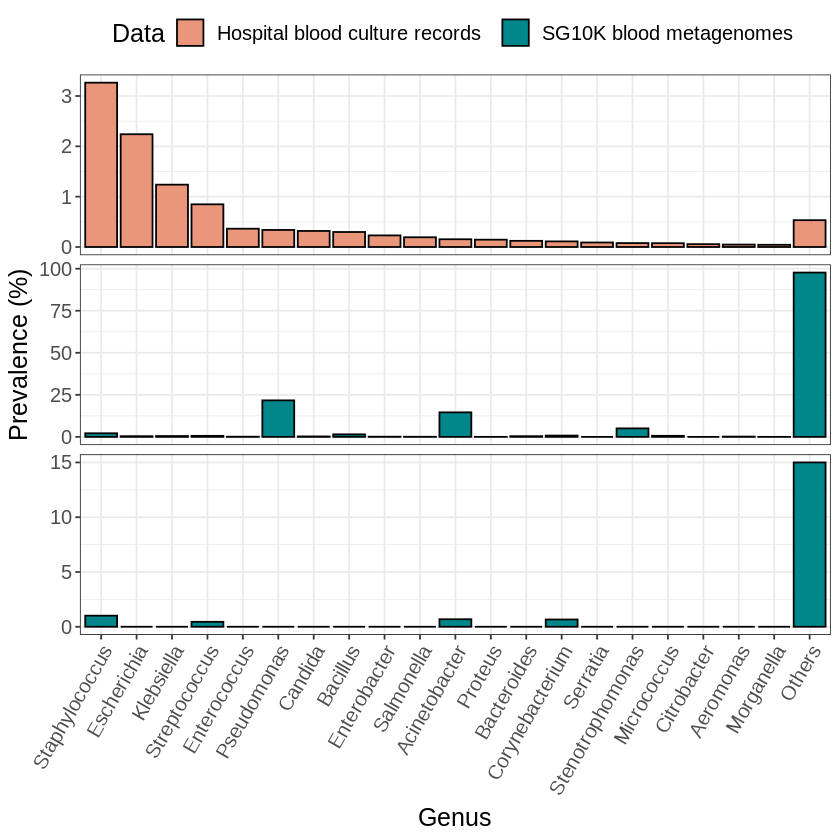

In [11]:
plot_df <- bind_rows(morsels) %>%
    left_join(blood_df) %>%
    mutate(prop_cultured = n / n_ids,
           prop_sequenced = n_sequenced / nrow(prev_df),
           prop_sequenced_nc = n_sequenced_nc / nrow(prev_df),
           prop_nc = n_nc / length(nc)) %>%
    select(genus, prop_cultured, prop_sequenced, prop_sequenced_nc) %>%
    pivot_longer(!genus, names_to = "stat", values_to = "value")

plot_df <- plot_df %>% 
    mutate(genus = factor(genus, unique(plot_df$genus))) %>%
    mutate(stat = factor(stat , c("prop_cultured", "prop_sequenced",
                                  "prop_sequenced_nc", "prop_nc"))) %>%
    mutate(data_type = ifelse(stat == "prop_cultured", "Hospital blood culture records", "SG10K blood metagenomes"))

plot_df %>%
    ggplot(aes(x = genus, y = value * 100, fill = data_type)) +
    geom_bar(stat = "identity", color = "black") +
    facet_grid(rows = vars(stat), scales = "free_y") +
    labs(x = "Genus", y = "Prevalence (%)", fill = "Data") +
    scale_fill_manual(values = c("darksalmon", "turquoise4", "turquoise4")) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1),
          legend.position = "top",
          strip.background = element_blank(),
          strip.text = element_blank(),
          text = element_text(size = 15))
ggsave("results/blood_culture_records/culture_versus_sequencing.pdf", dpi = 600)

In [12]:
plot_df %>%
    fwrite("results/figure_source_data_nat_micro/fig_2e_blood_culture_records.csv")

## Compare to Karius results

In [13]:
karius <- fread("data/blood_culture_records/karius_sepsis_data.csv")

karius_df <- karius %>% 
    separate(taxa, into = c("genus", "species1"), sep = " ") %>%
    filter(classification == "Definite") %>%
    mutate(genus = ifelse(genus == "Human", "Herpesvirus", genus)) %>%
    filter(!(genus %in% c("Herpesvirus", "Cytomegalovirus", "Torque"))) %>%
    group_by(genus) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

# Reclassify taxa into "Others"
karius_parsed <- karius_df %>%
    mutate(genus = ifelse(genus %in% karius_df$genus[1:5], genus, "Others")) %>%
    group_by(genus) %>%
    summarise(n = sum(n)) %>%
    arrange(desc(n))
karius_parsed

Warning message:
“Expected 2 pieces. Additional pieces discarded in 27 rows [11, 23, 47, 49, 58, 76, 82, 106, 125, 131, 137, 143, 145, 147, 159, 164, 166, 214, 218, 227, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [13, 198].”


genus,n
<chr>,<int>
Escherichia,50
Others,27
Streptococcus,11
Klebsiella,9
Proteus,5
Staphylococcus,5


In [18]:
karius_id <- karius %>% 
    separate(taxa, into = c("genus", "species1"), sep = " ") %>%
    filter(classification == "Definite") %>%
    nrow()

Warning message:
“Expected 2 pieces. Additional pieces discarded in 27 rows [11, 23, 47, 49, 58, 76, 82, 106, 125, 131, 137, 143, 145, 147, 159, 164, 166, 214, 218, 227, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [13, 198].”


Joining with `by = join_by(genus)`


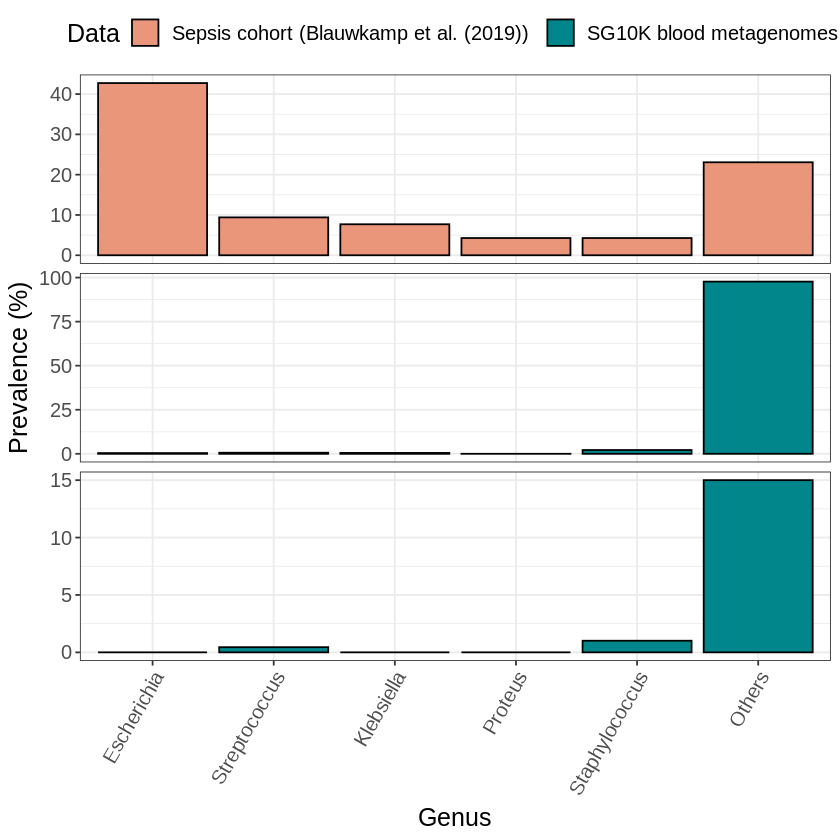

In [24]:
plot_df <- bind_rows(morsels) %>%
    right_join(karius_parsed) %>%
    mutate(prop_cultured = n / karius_id,
           prop_sequenced = n_sequenced / nrow(prev_df),
           prop_sequenced_nc = n_sequenced_nc / nrow(prev_df),
           prop_nc = n_nc / length(nc)) %>%
    select(genus, prop_cultured, prop_sequenced, prop_sequenced_nc) %>%
    pivot_longer(!genus, names_to = "stat", values_to = "value")

plot_df <- plot_df %>% 
    mutate(genus = factor(genus, c(unique(karius_df$genus), "Others"))) %>%
    mutate(stat = factor(stat , c("prop_cultured", "prop_sequenced",
                                  "prop_sequenced_nc", "prop_nc"))) %>%
    mutate(data_type = ifelse(stat == "prop_cultured", "Sepsis cohort (Blauwkamp et al. (2019))", "SG10K blood metagenomes"))

plot_df %>%
    ggplot(aes(x = genus, y = value * 100, fill = data_type)) +
    geom_bar(stat = "identity", color = "black") +
    facet_grid(rows = vars(stat), scales = "free_y") +
    labs(x = "Genus", y = "Prevalence (%)", fill = "Data") +
    scale_fill_manual(values = c("darksalmon", "turquoise4", "turquoise4")) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 60, hjust = 1),
          legend.position = "top",
          strip.background = element_blank(),
          strip.text = element_blank(),
          text = element_text(size = 15))
ggsave("results/blood_culture_records/karius_versus_sequencing.pdf", dpi = 600, height = 6.5, width = 7.5)

In [25]:
plot_df %>%
    fwrite("results/figure_source_data_nat_micro/ext_data_fig_3_blood_culture_records.csv")

